#  پیش‌بینی تایید وام با استفاده از یادگیری ماشین

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from google.colab import files
uploaded = files.upload()


# بارگذاری داده
df = pd.read_csv('loan.csv')
df.head()


Saving loan.csv to loan (1).csv


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


##  بررسی و مدیریت مقادیر گمشده

In [ ]:

# بررسی مقادیر گمشده
df.isnull().sum()


,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14
Credit_History,50


In [ ]:

# مدیریت مقادیر گمشده
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='mean')

df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
df[num_cols] = imputer_num.fit_transform(df[num_cols])


##  کدگذاری متغیرهای غیر عددی

In [ ]:

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


##  تقسیم داده‌ها به آموزش، اعتبارسنجی و تست

In [ ]:

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# تقسیم به تست و بقیه
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
# تقسیم آموزش و اعتبارسنجی
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2353, random_state=42, stratify=y_train_val)


##  نرمال‌سازی داده‌های عددی

In [ ]:

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


##  بخش بهبود: مهندسی ویژگی (Total_Income)

In [ ]:

df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']


##  بخش بهبود: استفاده از SMOTE برای بالانس کلاس‌ها

In [ ]:

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)


##  آموزش مدل‌ها

In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "ANN": MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000)
}

for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_val_scaled)
    print(classification_report(y_val, preds))



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.51      0.53      0.52        38
           1       0.79      0.78      0.78        85

    accuracy                           0.70       123
   macro avg       0.65      0.65      0.65       123
weighted avg       0.70      0.70      0.70       123


Model: KNN
              precision    recall  f1-score   support

           0       0.48      0.53      0.50        38
           1       0.78      0.74      0.76        85

    accuracy                           0.67       123
   macro avg       0.63      0.63      0.63       123
weighted avg       0.68      0.67      0.68       123


Model: ANN
              precision    recall  f1-score   support

           0       0.50      0.53      0.51        38
           1       0.78      0.76      0.77        85

    accuracy                           0.69       123
   macro avg       0.64      0.65      0.64       123
weighted avg       0.7

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


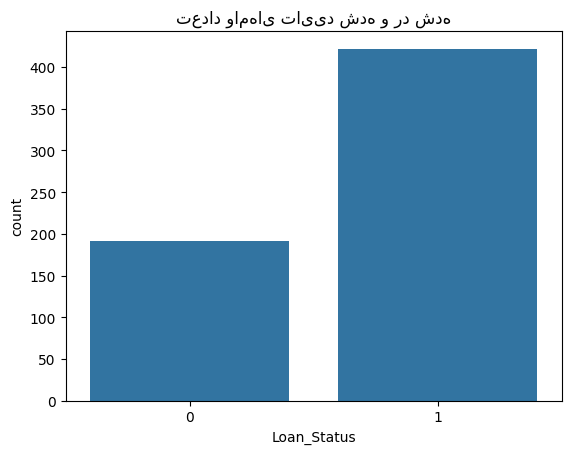

In [ ]:
# نمودار تعداد درخواست‌های تایید شده و نشده
sns.countplot(data=df, x='Loan_Status')
plt.title('تعداد وام‌های تایید شده و رد شده')
plt.show()


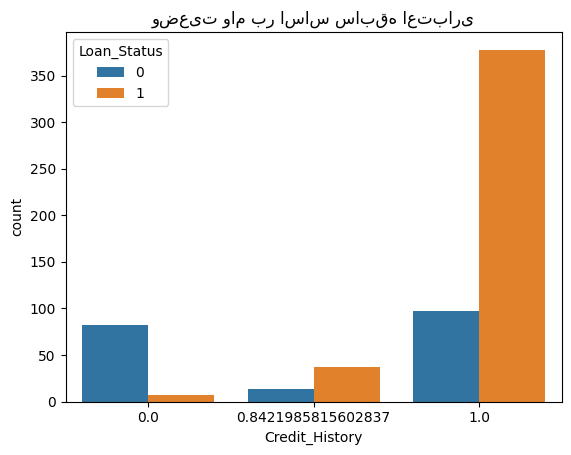

In [ ]:
# تحلیل ارتباط بین سابقه اعتباری و وضعیت وام
sns.countplot(data=df, x='Credit_History', hue='Loan_Status')
plt.title('وضعیت وام بر اساس سابقه اعتباری')
plt.show()


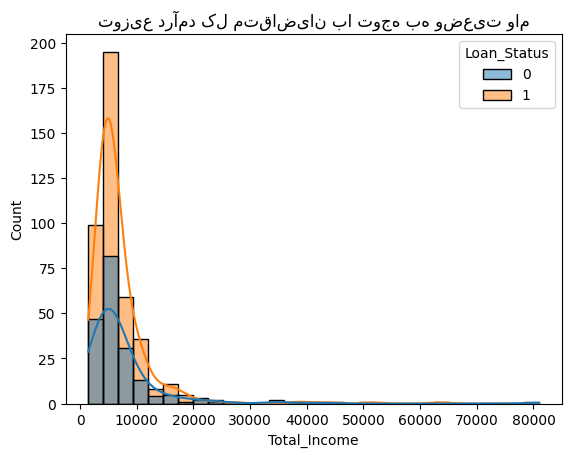

In [ ]:
# بررسی Total_Income در برابر وضعیت وام
if 'Total_Income' not in df.columns:
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
sns.histplot(data=df, x='Total_Income', hue='Loan_Status', bins=30, kde=True)
plt.title('توزیع درآمد کل متقاضیان با توجه به وضعیت وام')
plt.show()


##  ارزیابی نهایی مدل‌ها روی داده تست



In [ ]:

for name, model in models.items():
    print(f"\nModel: {name}")
    test_preds = model.predict(X_test_scaled)
    print(classification_report(y_test, test_preds))



Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        29
           1       0.87      0.91      0.89        64

    accuracy                           0.84        93
   macro avg       0.82      0.80      0.81        93
weighted avg       0.84      0.84      0.84        93


Model: KNN
              precision    recall  f1-score   support

           0       0.54      0.66      0.59        29
           1       0.83      0.75      0.79        64

    accuracy                           0.72        93
   macro avg       0.69      0.70      0.69        93
weighted avg       0.74      0.72      0.73        93


Model: ANN
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        29
           1       0.82      0.78      0.80        64

    accuracy                           0.73        93
   macro avg       0.69      0.70      0.70        93
weighted avg       0.7